In [1]:
import os
import boto3
import re
import sagemaker


role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for training data.
# Feel free to specify a different bucket and prefix.
data_bucket = f"convscraper"
data_prefix = "json"


# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
output_bucket = f"convscraper"
output_prefix = "notebooks"

In [2]:
s3 = boto3.client("s3")
articles19 = "2019articles.json"
comments19 = "2019commenters.json"
articles20 = "2020articles.json"
comments20 = "2020commenters.json"
s3.download_file(data_bucket, f"{data_prefix}/{articles19}", articles19)
s3.download_file(data_bucket, f"{data_prefix}/{comments19}", comments19)
s3.download_file(data_bucket, f"{data_prefix}/{articles20}", articles20)
s3.download_file(data_bucket, f"{data_prefix}/{comments20}", comments20)

modeldata = "modeldata.csv"
s3.download_file(data_bucket, f"{data_prefix}/{modeldata}", modeldata)

In [3]:
import pandas as pd

data = pd.read_csv(modeldata)


In [443]:
dfa19 = pd.read_json(articles19)
dfa20 = pd.read_json(articles20)

In [257]:
dfc19 = pd.read_json(comments19)
dfc20 = pd.read_json(comments20)

In [4]:
# Preview Data
data.head()

,Unnamed: 0,text,emotions
0,0,i feel awful about it too because it s my job ...,sadness
1,1,im alone i feel awful,sadness
2,3,i was feeling a little low few days back,sadness
3,11,i also feel disillusioned that someone who cla...,sadness
4,16,i wish you knew every word i write i write for...,sadness


In [5]:
# Merge fear and sadness
data.loc[data['emotions']=='fear', 'emotions'] = 'sadness'

In [6]:
# Merge fear and sadness
data.loc[data['emotions']=='sadness', 'emotions'] = 'depressed'
data.loc[data['emotions']=='joy', 'emotions'] = 'happy'

In [7]:
# Shuffle up the dataset
data = data.sample(frac=1).reset_index(drop=True)

(141067, 3)
(168899, 3)


<AxesSubplot:>

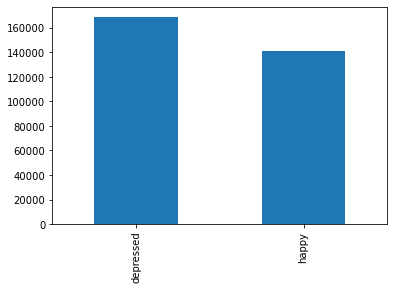

In [8]:
# Visualize the Samples
print(data[data['emotions']=='happy'].shape)
print(data[data['emotions']=='depressed'].shape)

# Plotting Graph
data.emotions.value_counts().plot.bar()

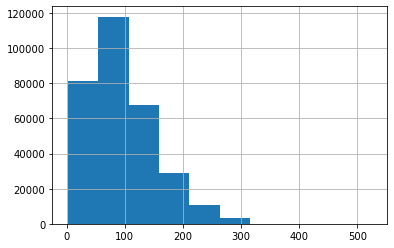

count    309966.000000
mean         96.233003
std          55.920283
min           2.000000
25%          53.000000
50%          85.000000
75%         127.000000
max         525.000000
dtype: float64

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Analyzing Review Lengths
reviews = [len(x) for x in data['text']]
pd.Series(reviews).hist()
plt.show()

# Summarizing the Analysis
pd.Series(reviews).describe()

In [10]:
import re

# Converting to lower case
data['text'] = data['text'].apply(lambda x: x.lower())

# Removing Punctuations
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [11]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenizing the text using in-built function
tokenizer = Tokenizer(num_words = 5000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

# The function map the words to integers, ands also pads the sentences, wherever required  
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [15]:
# Encoding the Labels
Y = pd.get_dummies(data['emotions']).values

In [16]:
from sklearn.model_selection import train_test_split

# Splitting the Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(185979, 96) (185979, 2)
(123987, 96) (123987, 2)


In [17]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# Defining Model Architecture
model = Sequential()

model.add(Embedding(5000, 64, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 96, 64)            320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 96, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 353,154
Trainable params: 353,154
Non-trainable params: 0
_________________________________________________________________
None


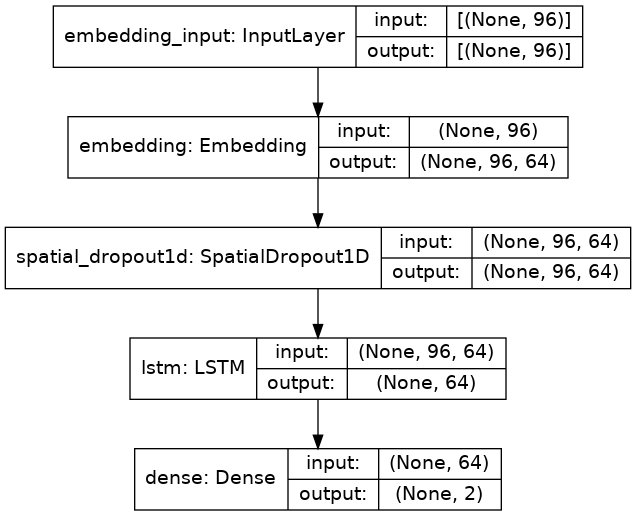

In [18]:
from keras.utils.vis_utils import plot_model

# Plotting Model Architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
# Training the Model
batch_size = 16
model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 1)

Epoch 1/3
11624/11624 [==============================] - 896s 76ms/step - loss: 0.1304 - accuracy: 0.9384
Epoch 2/3
11624/11624 [==============================] - 881s 76ms/step - loss: 0.0088 - accuracy: 0.9966
Epoch 3/3
11624/11624 [==============================] - 879s 76ms/step - loss: 0.0060 - accuracy: 0.9980


In [20]:
# Saving the Model
model.save('model2')

INFO:tensorflow:Assets written to: model2/assets


In [21]:
model = keras.models.load_model('model2')

In [23]:
import numpy as np

In [24]:
# Predicting the Results
y_pred = model.predict(X_test)
y_pred = np.array([[1 if x > 0.5 else 0 for x in y ] for y in y_pred])

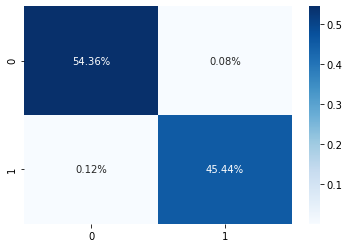

In [25]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred, average='micro'))
print("AUC ROC:", roc_auc_score(Y_test, y_pred, multi_class='ovr'))
print("Log Loss:", log_loss(Y_test, y_pred))

Accuracy: 0.9980643131941251
F1 Score: 0.9980643131941251
AUC ROC: 0.9980114086382833
Log Loss: 0.06685625375868992


In [429]:
def Predictor(twt):
    if twt == '':
        return 'null'
    else:
        twt = tokenizer.texts_to_sequences(twt)
        twt = pad_sequences(twt, maxlen = 96, dtype = 'int32', value = 0)
        sentiment = model.predict(twt ,batch_size = 1, verbose = 0)[0]
        sentiment = [float(i)/sum(sentiment) for i in sentiment]
        if (sentiment[0]*100)>65:
            return 'depressed'
        else:
            return 'happy'
  #print(f"Depression: {(sentiment[0]*100)}")
  #print(f"happiness: {(sentiment[1]*100)}")

In [444]:
dfa19 = dfa19.T
dfa20 = dfa20.T

In [461]:
dfc19 = dfc19.T
dfc20 = dfc20.T

In [445]:
dfa19.shape
dfa19.head()

,author,title,body,url,date_created,subreddit,subreddit_subscribers
c7kizh,bodyaga,My course starts in 2 days and I still don’t k...,I have registered for LAWS 1002 V and for disc...,https://www.reddit.com/r/CarletonU/comments/c7...,1.56193e+09,CarletonU,6808
c7hpws,swarlypants,OSAP question,Does anyone know what happens to your OSAP if ...,https://www.reddit.com/r/CarletonU/comments/c7...,1.56192e+09,CarletonU,6808
c7gb3h,NeonNutella,Off campus housing?,Hey! I'll be living with my friend and we're l...,https://www.reddit.com/r/CarletonU/comments/c7...,1.56191e+09,CarletonU,6808
c7fv1c,lovedoraemon,Gym at carleton?,I will be a full time student living on campus...,https://www.reddit.com/r/CarletonU/comments/c7...,1.56191e+09,CarletonU,6808
c7ftve,Eternal_Student2024,Which OSAP option for COOP workterm?,So I posted here previously about OSAP and co-...,https://www.reddit.com/r/CarletonU/comments/c7...,1.56191e+09,CarletonU,6808


In [446]:
dfa20.shape
dfa20.head()

,author,title,body,url,date_created,subreddit,subreddit_subscribers
fbl38p,CaptainAaron96,Is there a way to get into Steacie on weekends...,,https://www.reddit.com/r/CarletonU/comments/fb...,1.58302e+09,CarletonU,9123
fbl02w,rianatn,CarletonU or UTM?,[removed],https://www.reddit.com/r/CarletonU/comments/fb...,1.58302e+09,CarletonU,9123
fbj38k,Fredditotk,Why is Carleton CS so expensive compared to ot...,https://cudo.ouac.on.ca/page.php?id=7&amp;tabl...,https://www.reddit.com/r/CarletonU/comments/fb...,1.58301e+09,CarletonU,9121
fbj29z,harveygang,Does CarletonU have an open studies type option?,[removed],https://www.reddit.com/r/CarletonU/comments/fb...,1.58301e+09,CarletonU,9121
fbi4sn,CheggAbuser,What was that midterm.....,,https://i.redd.it/pblqz1tb5xj41.jpg,1.58301e+09,CarletonU,9120


In [467]:
dfc19.shape
dfc19.head()

,article_id,parent_id,author,body,date_created,subreddit,body_sentiment
esfx7zm,t3_c7kizh,t3_c7kizh,CronosDage,It isn't realistic to expect the course to be ...,1.56194e+09,CarletonU,<NA>
esfwz4u,t3_c7ftve,t3_c7ftve,Thatdoctorperson,If you click the my program isnt listed here b...,1.56194e+09,CarletonU,<NA>
esfwcbk,t3_c6qgh8,t1_esdsqur,ap_101,Any chance you could pass me the syllabus or s...,1.56194e+09,CarletonU,<NA>
esfvt9k,t3_c7kizh,t1_esfvszw,nkid299,I like your style : ),1.56194e+09,CarletonU,<NA>
esfvszw,t3_c7kizh,t3_c7kizh,ap_101,my course still hasnt shown up on culearn but ...,1.56194e+09,CarletonU,<NA>


In [468]:
dfc20.shape
dfc20.head()

,article_id,parent_id,author,body,date_created,subreddit,body_sentiment
fj4zikp,t3_fatrdq,t3_fatrdq,lama8,Whoever posted this is very white. Most peop...,1.58302e+09,CarletonU,<NA>
fj4z7m3,t3_fatrdq,t1_fj0g847,pearlescentpink,"Sorry, I’m kind of confused by your comment? I...",1.58302e+09,CarletonU,<NA>
fj4ylue,t3_faz05t,t3_faz05t,pearlescentpink,Talk to your department head and if you’re a P...,1.58302e+09,CarletonU,<NA>
fj4y1a0,t3_fbhm7l,t3_fbhm7l,pearlescentpink,Loeb is pretty awful for the spring session. E...,1.58302e+09,CarletonU,<NA>
fj4ug2n,t3_f58ewv,t1_fhz71mj,chien_errant,this helped a lot thank you :),1.58302e+09,CarletonU,<NA>


In [448]:
dfa19['body'].replace(['[removed]'], '', regex=False, inplace=True)
dfa19['body'].replace(['[deleted]'], '', regex=False, inplace=True)


dfa20['body'].replace(['[removed]'], '', regex=False, inplace=True)
dfa20['body'].replace(['[deleted]'], '', regex=False, inplace=True)

In [447]:
dfa19.isnull().sum()

author                   0
title                    0
body                     0
url                      0
date_created             0
subreddit                0
subreddit_subscribers    0
dtype: int64

In [266]:
dfa20.isnull().sum()

author                       0
title                        0
body                      8130
url                          0
date_created                 0
subreddit                    0
subreddit_subscribers        0
title_sentiment          41590
body_sentiment           41590
dtype: int64

In [36]:
dfc19.isnull().sum()

article_id      0
parent_id       0
author          0
body            0
date_created    0
subreddit       0
dtype: int64

In [37]:
dfc20.isnull().sum()

article_id      0
parent_id       0
author          0
body            0
date_created    0
subreddit       0
dtype: int64

In [449]:
dfa19.loc[:, 'title_sentiment'] = pd.Series()
dfa20.loc[:, 'title_sentiment'] = pd.Series()
dfa19.loc[:, 'body_sentiment'] = pd.Series()
dfa20.loc[:, 'body_sentiment'] = pd.Series()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The default dtype fo

In [465]:
dfc19.loc[:, 'body_sentiment'] = pd.Series()
dfc20.loc[:, 'body_sentiment'] = pd.Series()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


In [450]:
dfa19['title_sentiment'] = dfa19['title_sentiment'].astype('string')
dfa19['body_sentiment'] = dfa19['body_sentiment'].astype('string')
dfa19['title'] = dfa19['title'].astype('string')
dfa19['body'] = dfa19['body'].astype('string')

dfa20['title_sentiment'] = dfa20['title_sentiment'].astype('string')
dfa20['body_sentiment'] = dfa20['body_sentiment'].astype('string')
dfa20['title'] = dfa20['title'].astype('string')
dfa20['body'] = dfa20['body'].astype('string')

In [466]:
dfc19['body_sentiment'] = dfc19['body_sentiment'].astype('string')
dfc19['body'] = dfc19['body'].astype('string')

dfc20['body_sentiment'] = dfc20['body_sentiment'].astype('string')
dfc20['body'] = dfc20['body'].astype('string')

In [451]:
dfa19['title_sentiment'] = dfa19.progress_apply(lambda row: Predictor([row['title']]), axis=1)

100%|██████████| 69396/69396 [36:55<00:00, 31.33it/s]  


In [452]:
dfa20['title_sentiment'] = dfa20.progress_apply(lambda row: Predictor([row['title']]), axis=1)

100%|██████████| 41590/41590 [21:30<00:00, 32.23it/s]  


In [453]:
dfa19['body_sentiment'] = dfa19.progress_apply(lambda row: Predictor([row['body']]), axis=1)

100%|██████████| 69396/69396 [35:15<00:00, 32.81it/s]  


In [454]:
dfa20['body_sentiment'] = dfa20.progress_apply(lambda row: Predictor([row['body']]), axis=1)

100%|██████████| 41590/41590 [21:01<00:00, 32.97it/s]  


In [455]:
dfa19.to_csv('dfa19sentiment.csv')

In [456]:
dfa20.to_csv('dfa20sentiment.csv')

In [161]:
pip install tqdm

     |████████████████████████████████| 75 kB 8.0 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [162]:
from tqdm import tqdm

In [348]:
tqdm.pandas()

In [471]:
dfc19['body_sentiment'] = dfc19.progress_apply(lambda row: Predictor([row['body']]), axis=1)

100%|██████████| 364624/364624 [3:22:21<00:00, 30.03it/s]  


In [472]:
dfc19.to_csv('dfc19sentiment.csv')

In [ ]:
dfc20['body_sentiment'] = dfc20.progress_apply(lambda row: Predictor([row['body']]), axis=1)

100%|██████████| 216078/216078 [2:11:40<00:00, 27.35it/s]  


In [479]:
dfc20.to_csv('dfc20sentiment.csv')

In [83]:
for i in range (5):
  dfa20['title_sentiment'][i] = Predictor([dfa20["title"][i]])

In [470]:
dfc20

,article_id,parent_id,author,body,date_created,subreddit,body_sentiment
fj4zikp,t3_fatrdq,t3_fatrdq,lama8,Whoever posted this is very white. Most peop...,1.58302e+09,CarletonU,<NA>
fj4z7m3,t3_fatrdq,t1_fj0g847,pearlescentpink,"Sorry, I’m kind of confused by your comment? I...",1.58302e+09,CarletonU,<NA>
fj4ylue,t3_faz05t,t3_faz05t,pearlescentpink,Talk to your department head and if you’re a P...,1.58302e+09,CarletonU,<NA>
fj4y1a0,t3_fbhm7l,t3_fbhm7l,pearlescentpink,Loeb is pretty awful for the spring session. E...,1.58302e+09,CarletonU,<NA>
fj4ug2n,t3_f58ewv,t1_fhz71mj,chien_errant,this helped a lot thank you :),1.58302e+09,CarletonU,<NA>
...,...,...,...,...,...,...,...
fzxo8ne,t3_i1g17i,t1_fzxo0lz,TunicSauce,The problem is the options that they give me t...,1.59624e+09,yorku,<NA>
fzxo0lz,t3_i1g17i,t1_fzxn4bo,throwaway23uio,"Oh ok, damn. The way u said 8 million, i was l...",1.59624e+09,yorku,<NA>
fzxnm59,t3_i1g17i,t1_fzxhdeo,TunicSauce,Computer science,1.59624e+09,yorku,<NA>
fzxnhyu,t3_i1g17i,t1_fzxhdeo,TunicSauce,What I mean is that one Canadian dollar conver...,1.59624e+09,yorku,<NA>


In [459]:
dfa20

,author,title,body,url,date_created,subreddit,subreddit_subscribers,title_sentiment,body_sentiment
fbl38p,CaptainAaron96,Is there a way to get into Steacie on weekends...,,https://www.reddit.com/r/CarletonU/comments/fb...,1.58302e+09,CarletonU,9123,depressed,depressed
fbl02w,rianatn,CarletonU or UTM?,,https://www.reddit.com/r/CarletonU/comments/fb...,1.58302e+09,CarletonU,9123,depressed,depressed
fbj38k,Fredditotk,Why is Carleton CS so expensive compared to ot...,https://cudo.ouac.on.ca/page.php?id=7&amp;tabl...,https://www.reddit.com/r/CarletonU/comments/fb...,1.58301e+09,CarletonU,9121,depressed,depressed
fbj29z,harveygang,Does CarletonU have an open studies type option?,,https://www.reddit.com/r/CarletonU/comments/fb...,1.58301e+09,CarletonU,9121,happy,depressed
fbi4sn,CheggAbuser,What was that midterm.....,,https://i.redd.it/pblqz1tb5xj41.jpg,1.58301e+09,CarletonU,9120,depressed,depressed
...,...,...,...,...,...,...,...,...,...
i1jnwk,canjeyre,Switching from Undeclared to AMPD for Winter?,"Heyoh, does anyone know how difficult it is to...",https://www.reddit.com/r/yorku/comments/i1jnwk...,1.59624e+09,yorku,15162,happy,happy
i1jlgo,yarishua,Look for friends:),"Hi, im going to be attending my first year at ...",https://www.reddit.com/r/yorku/comments/i1jlgo...,1.59624e+09,yorku,15162,happy,happy
i1izgf,BrutalNasher,Course Enrollment Issue,Hello. When accessing YU Start and trying to u...,https://www.reddit.com/r/yorku/comments/i1izgf...,1.59624e+09,yorku,15162,happy,happy
i1ixqr,jessicasingh0,Easy HUMA courses?,,https://www.reddit.com/r/yorku/comments/i1ixqr...,1.59624e+09,yorku,15162,happy,depressed


In [478]:
dfc20.tail()

,article_id,parent_id,author,body,date_created,subreddit,body_sentiment
fzxo8ne,t3_i1g17i,t1_fzxo0lz,TunicSauce,The problem is the options that they give me t...,1.59624e+09,yorku,depressed
fzxo0lz,t3_i1g17i,t1_fzxn4bo,throwaway23uio,"Oh ok, damn. The way u said 8 million, i was l...",1.59624e+09,yorku,happy
fzxnm59,t3_i1g17i,t1_fzxhdeo,TunicSauce,Computer science,1.59624e+09,yorku,happy
fzxnhyu,t3_i1g17i,t1_fzxhdeo,TunicSauce,What I mean is that one Canadian dollar conver...,1.59624e+09,yorku,depressed
fzxn4bo,t3_i1g17i,t1_fzxn12p,TunicSauce,About 25K,1.59624e+09,yorku,depressed
